In [39]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from model.yolov4 import YOLOv4
from config import *

# Paths
IMAGE_DIR = os.path.join(DATA_PATH, "images")
LABEL_DIR = os.path.join(DATA_PATH, "labels")
PRED_DIR = os.path.join(DATA_PATH, "predict")
os.makedirs(PRED_DIR, exist_ok=True)

# Load model
model = YOLOv4(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("./weights/yolov4.pth", map_location=DEVICE))
model.eval()

# Predict and save
predictions = {}
for img_file in sorted(os.listdir(IMAGE_DIR))[:50]:
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)
        preds = torch.cat([o.view(o.size(0), -1, 5 + NUM_CLASSES) for o in outputs], dim=1)
        preds = preds[0].cpu().numpy()

    pred_list = []
    for pred in preds:
        x, y, w, h, conf = pred[:5]
        if conf > 0.5:
            pred_list.append([x, y, w, h, conf])
    predictions[img_file] = pred_list

    with open(os.path.join(PRED_DIR, img_file.replace(".jpg", ".txt")), "w") as f:
        for x, y, w, h, conf in pred_list:
            f.write(f"0 {x:.6f} {y:.6f} {w:.6f} {h:.6f} {conf:.6f}\n")


In [40]:
correct, total = 0, 0
def compute_iou(box1, box2):
    x1_min, y1_min = box1[0] - box1[2]/2, box1[1] - box1[3]/2
    x1_max, y1_max = box1[0] + box1[2]/2, box1[1] + box1[3]/2
    x2_min, y2_min = box2[0] - box2[2]/2, box2[1] - box2[3]/2
    x2_max, y2_max = box2[0] + box2[2]/2, box2[1] + box2[3]/2

    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)
    inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

for img_file in predictions:
    pred_boxes = predictions[img_file]
    label_path = os.path.join(LABEL_DIR, img_file.replace(".jpg", ".txt"))
    if not os.path.exists(label_path): continue
    with open(label_path, "r") as f:
        gt_boxes = [list(map(float, line.strip().split()[1:5])) for line in f]

    matched = [False] * len(gt_boxes)
    for pred in pred_boxes:
        for i, gt in enumerate(gt_boxes):
            if not matched[i] and compute_iou(pred, gt) > 0.5:
                matched[i] = True
                correct += 1
                break
    total += len(gt_boxes)

accuracy = correct / total if total > 0 else 0
print(f"Detection Accuracy (IoU > 0.5): {accuracy:.2%}")

Detection Accuracy (IoU > 0.5): 85.80%


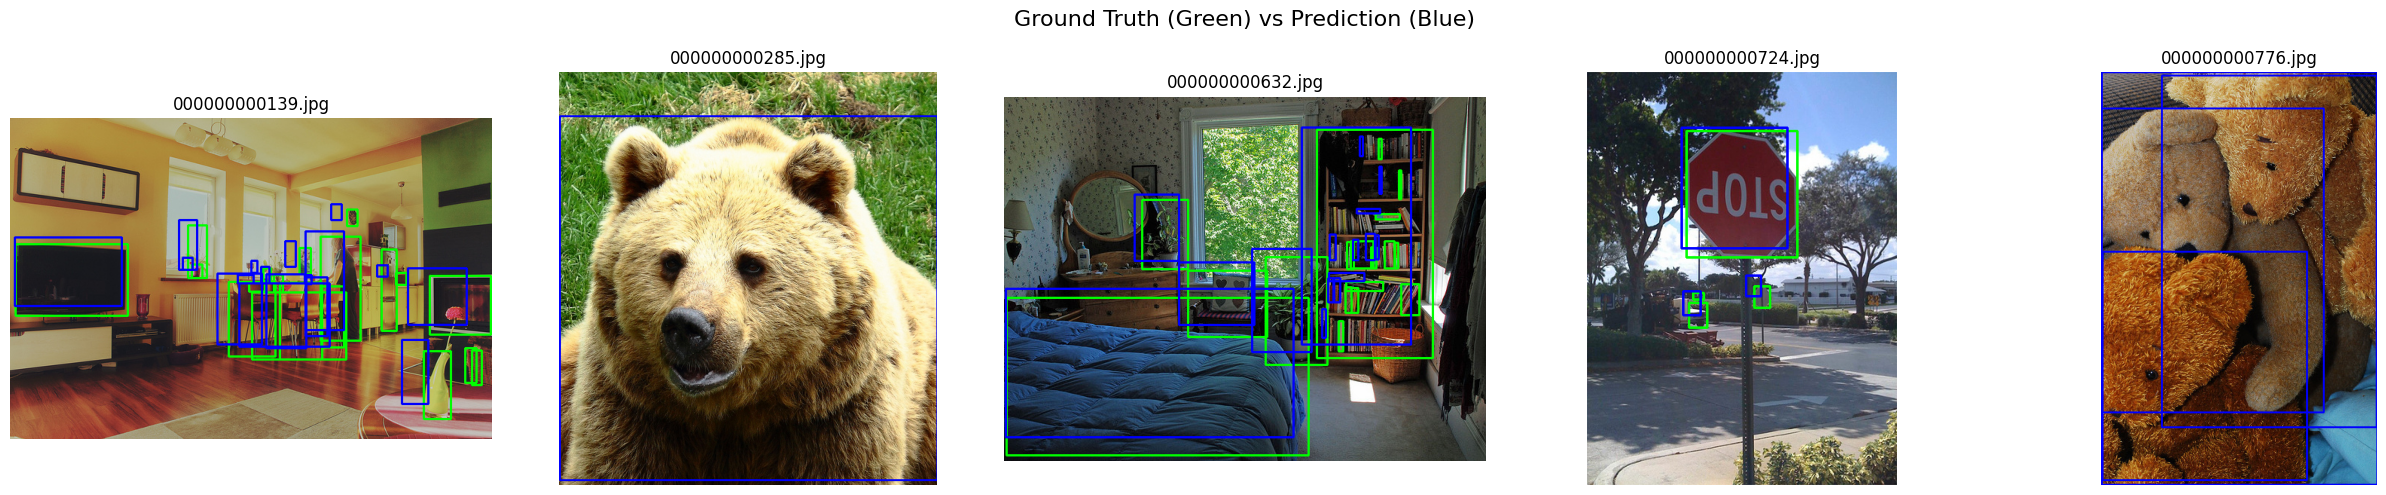

In [41]:
import os
import cv2
import matplotlib.pyplot as plt

PRED_DIR = os.path.join(DATA_PATH, "predict")
LABEL_DIR = os.path.join(DATA_PATH, "labels")
IMAGE_DIR = os.path.join(DATA_PATH, "images")

def load_boxes_from_file(txt_path):
    boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    x, y, w, h = map(float, parts[1:5])
                    boxes.append([x, y, w, h])
    return boxes

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, filename in enumerate(sorted(os.listdir(PRED_DIR))[1:6]):
    if not filename.endswith(".txt"):
        continue

    image_file = filename.replace(".txt", ".jpg")
    image_path = os.path.join(IMAGE_DIR, image_file)
    label_path = os.path.join(LABEL_DIR, filename)
    pred_path = os.path.join(PRED_DIR, filename)

    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    gt_boxes = load_boxes_from_file(label_path)
    pred_boxes = load_boxes_from_file(pred_path)

    for x, y, bw, bh in gt_boxes:
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green = GT

    for x, y, bw, bh in pred_boxes:
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue = Prediction

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(image_file)
    axes[i].axis("off")

plt.suptitle("Ground Truth (Green) vs Prediction (Blue)", fontsize=16)
plt.tight_layout()
plt.show()
